## Where do the best recruits come from and where do they go to school? 

In [48]:
# Uncomment and run line below if libraries aren't already installed
#! pip install cfbd
# !pip install geopy


In [49]:
import numpy as np
import pandas as pd
import altair as alt
import cfbd
import pandas as pd 

pd.set_option('display.max_columns', None)

In [50]:
df_teams = pd.read_csv('../data/teams.csv')
df_recruits = pd.read_csv('../data/recruits.csv')

#### Merge two datasets together based on the school the recruit went to

In [51]:
df_merged = pd.merge(left = df_recruits, right = df_teams, left_on = 'committed_to', right_on = 'school', how = 'inner')

col = ['year', 'ranking', 'name', 'committed_to', 'position', 'height', \
       'weight', 'stars', 'rating', 'latitude', 'longitude', 'state_province',\
       'school_y', 'conference', 'color', 'logos', 'latitude_school', 'longitude_school']

df_merged = df_merged[col]
df_merged['four_star_or_better'] = np.where(df_merged['stars'] >= 4, 1, 0) # Flag saying whether recruit is a 4 star

df_merged.head()

,year,ranking,name,committed_to,position,height,weight,stars,rating,latitude,longitude,state_province,school_y,conference,color,logos,latitude_school,longitude_school,four_star_or_better
0,2015,1.0,Trenton Thompson,Georgia,DT,74.0,313.0,5,0.9992,31.578206,-84.155681,GA,Georgia,SEC,#CC0000,http://a.espncdn.com/i/teamlogos/ncaa/500/61.png,33.94982,-83.373381,1
1,2015,1.0,Trent Thompson,Georgia,DT,74.5,313.0,5,0.9991,31.578206,-84.155681,GA,Georgia,SEC,#CC0000,http://a.espncdn.com/i/teamlogos/ncaa/500/61.png,33.94982,-83.373381,1
2,2015,27.0,Terry Godwin,Georgia,ATH,72.0,168.0,5,0.9879,33.173177,-84.914936,GA,Georgia,SEC,#CC0000,http://a.espncdn.com/i/teamlogos/ncaa/500/61.png,33.94982,-83.373381,1
3,2015,48.0,Roquan Smith,Georgia,OLB,74.0,207.0,4,0.9769,32.305158,-84.027407,GA,Georgia,SEC,#CC0000,http://a.espncdn.com/i/teamlogos/ncaa/500/61.png,33.94982,-83.373381,1
4,2015,65.0,Jonathan Ledbetter,Georgia,SDE,76.0,265.0,4,0.9680,33.853270,-84.220073,GA,Georgia,SEC,#CC0000,http://a.espncdn.com/i/teamlogos/ncaa/500/61.png,33.94982,-83.373381,1


##### Create the two datasets showing recruits by where the went to school vs where they came from

In [52]:
# Aggregate by recruit home town coordinates
geo_df = df_merged.groupby(by = ['longitude', 'latitude']).agg({'name': 'count', 'four_star_or_better': 'sum', 'stars': 'sum'})\
                  .reset_index()\
                  .rename({'name': 'recruits',  'four_star_or_better': '4+ Star Recruits'}, axis = 1)

In [53]:
# Aggregate by the location of where the recruit went to school

geo_df_school = df_merged.groupby(by = ['longitude_school', 'latitude_school']).agg({'name': 'count', 'four_star_or_better': 'sum', 'stars':'sum'})\
    .reset_index()\
    .rename({'name': 'recruits', 'four_star_or_better': '4+ Star Recruits'}, axis = 1)


### Create Heatmaps from the two datasets above 

In [54]:
# ! pip install plotly
import pandas as pd
import plotly.express as px

# Heatmatp of recruits by home town
fig = px.density_mapbox(geo_df, lat = 'latitude', lon = 'longitude', z = '4+ Star Recruits',
                        radius = 40,
                        center = dict(lat = 39, lon = -98),
                        zoom = 3.5,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        title = 'Heatmap of where 4 Star Recruits are From',
                        range_color = [0, 100])
#fig.write_image('recruit_home.png', auto_open=True)

fig.update_layout(
        title_text = 'Distribution of Football Recruiting Talent by Hometown Location',
        showlegend = True,
        # autosize = True,
        width = 1200,
        height = 700,
        margin_autoexpand = True,
        margin=dict(l=20, r=20, t=70, b=20),
        geo = dict(
            scope = 'north america',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
        
    )
# fig.write_image('recruits_school.png')

fig.show()

In [55]:
# Heatmap of recruits by school of choice
fig = px.density_mapbox(geo_df_school, lat = 'latitude_school', lon = 'longitude_school', z = '4+ Star Recruits',
                        radius = 40,
                        center = dict(lat = 39, lon = -98),
                        zoom = 3.5,
                        mapbox_style = 'open-street-map',
                        color_continuous_scale = 'rainbow',
                        range_color = [0, 100])

fig.update_layout(
        title_text = 'Distribution of Football Recruiting Talent by School of Choice',
        showlegend = True,
        # autosize = True,
        width = 1200,
        height = 700,
        margin_autoexpand = True,
        margin=dict(l=20, r=20, t=70, b=20),
        geo = dict(
            scope = 'north america',
            projection_type = 'azimuthal equal area',
            showland = True,
            landcolor = 'rgb(243, 243, 243)',
            countrycolor = 'rgb(204, 204, 204)',
        ),
        
    )

# fig.write_image('recruits_home.png')
fig.show()

### Sankey Diagram 

In [56]:
df_merged_copy = df_merged.copy()

df_merged_copy.dropna(subset=['longitude'], inplace=True)
df_merged_copy.dropna(subset=['latitude'], inplace=True)

df_merged_copy = df_merged_copy[df_merged_copy['year'] == 2019]

In [57]:
import geopy.distance

df_teams_dist = df_teams[df_teams['conference'].isin(['SEC', 'Big Ten', 'ACC', 'Pac-12', 'Big 12'])]

closest_school = []

# For every athlete, identify their home town coordinates
for i in df_merged_copy.iterrows():
    
    latitude_i = i[1]['latitude']
    longitude_i = i[1]['longitude']

    coords_1 = (latitude_i, longitude_i)

    # Check to see how far that is from every power 5 school
    # Save the school and distances for each school as list of tuples
    # select the school with the smallest distance associated with it
    # Append that school as an extra column (called closest_school) to original df

    school_dist = []
    for j in df_teams_dist.iterrows():

        school_j = j[1]['school']
        latitude_j = j[1]['latitude_school']
        longitude_j = j[1]['longitude_school']

        # Create sets of coordinates for school
        coords_2 = (latitude_j, longitude_j)

        # Calc didstance
        distance = geopy.distance.geodesic(coords_1, coords_2).mi

        # Create list of tuples for school name and distance from recruit (coords_1)
        combined_j = (school_j, distance)
        school_dist.append(combined_j)

        # ID the school with the min distance
        closest_school_i = min(school_dist, key=lambda item: item[1])[0]
    
    # Append that school's name for that recruit
    closest_school.append(closest_school_i)

# Add as column to df
df_merged_copy['closest_school'] = closest_school



In [58]:
# Joining, reducing columns, and aggregation for visual
df_merged_final = pd.merge(left = df_merged_copy, right = df_teams, left_on = 'closest_school', right_on = 'school')
df_merged_final = df_merged_final.rename({'conference_x': 'comm_conf', 'conference_y': 'orig_conf'}, axis = 1)

col = ['year', 'name', 'committed_to', 'comm_conf', 'state_province', 'latitude', 'longitude', 'closest_school', 'orig_conf']
df_merged_final = df_merged_final[col]

df_merged_final = df_merged_final[df_merged_final['comm_conf'].isin(['SEC', 'Big Ten', 'ACC', 'Pac-12', 'Big 12'])]

# Aggregate and Simplify for Sankey diagram
df_sanky = df_merged_final.groupby(by = ['comm_conf', 'orig_conf']).agg({'name':'count'}).reset_index().rename({'name': 'count'}, axis = 1)

df_sanky = df_sanky[['orig_conf', 'comm_conf', 'count']]
df_sanky['comm_conf'] = df_sanky['comm_conf'].astype(str) + ' Desitination'
df_sanky['orig_conf'] = df_sanky['orig_conf'].astype(str) + ' Origin'

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
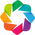

:Sankey   [orig_conf,comm_conf]   (count)

In [59]:
# Sankey Tutorial :
# https://medium.com/@cbkwgl/sankey-diagrams-in-python-fc9673465ccb

import pandas as pd
import holoviews as hv

hv.extension('bokeh')
# edges = pd.read_csv('data/health-breakup2.csv')
sankey = hv.Sankey(df_sanky, label='A Breakout of Where Recruits Come From and Where They Commit')
sankey.opts(label_position='left', edge_color='count', node_color='orig_conf', cmap='Category20c', width =800, height = 600)